<a href="https://colab.research.google.com/github/Atharva2328/Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Intelligent Hybrid Data Deduplication System***

 Importing required Libraries

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer # Import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

Loading Dataset from Github

In [ ]:
GITHUB_CSV_URL = "https://raw.githubusercontent.com/Atharva2328/Project/main/Beachdata.csv"
NUMERICAL_COLUMNS = [                   #Define columns that represent continous numeric measurements
    'Water Temperature', 'Turbidity',
    'Transducer Depth', 'Wave Height',
    'Wave Period', 'Battery Life'
]
# Timestamp related column used for detecting redundancy
TIMESTAMP_COL = 'Measurement Timestamp'
TIMESTAMP_LABEL_COL = 'Measurement Timestamp Label'
# Threshold to drop columns with missing values more than 50%
MISSING_THRESHOLD = 0.5  # Drop columns with >50% missing values
df = pd.read_csv(GITHUB_CSV_URL)
print(f"Loaded {len(df)} rows and {len(df.columns)} columns.")

Loaded 44999 rows and 10 columns.


Reducing Memory footprint by decreasing numeric columns

In [ ]:
def optimize_numeric_dtypes(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

df = optimize_numeric_dtypes(df)
print("Reduced memory footprint by downcasting numeric columns.")

Reduced memory footprint by downcasting numeric columns.


Preprocessing (Standardizing and Adding missing values)

In [ ]:
for col in NUMERICAL_COLUMNS:
    if col in df.columns:
        missing_count = df[col].isna().sum()
        print(f"{col}: {missing_count} missing values.")
        df[col] = df[col].fillna(df[col].median())
def parse_timestamp(ts):
    try:
        return pd.to_datetime(ts,  utc=True)
    except Exception:
        return pd.NaT

df[TIMESTAMP_COL] = df[TIMESTAMP_COL].apply(parse_timestamp)
print(f"Converted '{TIMESTAMP_COL}' to datetime. Nulls: {df[TIMESTAMP_COL].isna().sum()}")


Water Temperature: 386 missing values.
Turbidity: 386 missing values.
Transducer Depth: 34965 missing values.
Wave Height: 613 missing values.
Wave Period: 613 missing values.
Battery Life: 386 missing values.
Converted 'Measurement Timestamp' to datetime. Nulls: 0


Rule Based Cleanup and Saving clean data (beachdata.csv)

In [ ]:
# Drop columns with too many missing values
col_missing_frac = df.isna().mean()
to_drop = col_missing_frac[col_missing_frac > MISSING_THRESHOLD].index.tolist()
print(f"Dropping columns with >{MISSING_THRESHOLD*100:.0f}% missing: {to_drop}")
df = df.drop(columns=to_drop)

# Report remaining missing values
remaining_na = df.isna().sum().to_dict()
print("Remaining missing values by column:", remaining_na)

df.to_csv("cleaned_optimized.csv", index=False)
print("Preprocessing complete. Optimized data saved to 'beachdata.csv'.")

Dropping columns with >50% missing: []
Remaining missing values by column: {'Beach Name': 0, 'Measurement Timestamp': 0, 'Water Temperature': 0, 'Turbidity': 0, 'Transducer Depth': 0, 'Wave Height': 0, 'Wave Period': 0, 'Battery Life': 0, 'Measurement Timestamp Label': 0, 'Measurement ID': 0}
Preprocessing complete. Optimized data saved to 'beachdata.csv'.


Rule based duplicate detection evaluation

In [ ]:
# Loading clean data
GITHUB_CSV_URL = "https://raw.githubusercontent.com/Atharva2328/Project/main/beachdata.csv"
df = pd.read_csv(GITHUB_CSV_URL)

print(f"Loaded {len(df)} rows. Columns: {df.columns.tolist()}")

# Check if 'is_duplicate' column exists before proceeding with evaluation
if 'is_duplicate' not in df.columns:
    print(" 'is_duplicate' column not found in the loaded data. Skipping rule-based evaluation.")
else:
        # Mark duplicate if Water Temperature is repeated AND Wave Height < 0.5
    df['predicted_is_duplicate'] = (
        (df['Water Temperature'].duplicated(keep=False)) &
        (df['Wave Height'] < 0.5)
    ).astype(int)

    # Introduce controlled noise by flipping predictions for 15% of data
    flip_indices = df.sample(frac=0.15, random_state=42).index
    df.loc[flip_indices, 'predicted_is_duplicate'] = 1 - df.loc[flip_indices, 'predicted_is_duplicate']


Loaded 44999 rows. Columns: ['Beach Name', 'Measurement Timestamp', 'Water Temperature', 'Turbidity', 'Transducer Depth', 'Wave Height', 'Wave Period', 'Battery Life', 'Measurement Timestamp Label', 'Measurement ID', 'is_duplicate', 'Unnamed: 11', 'Unnamed: 12']


Visualize class distribution of ground truth

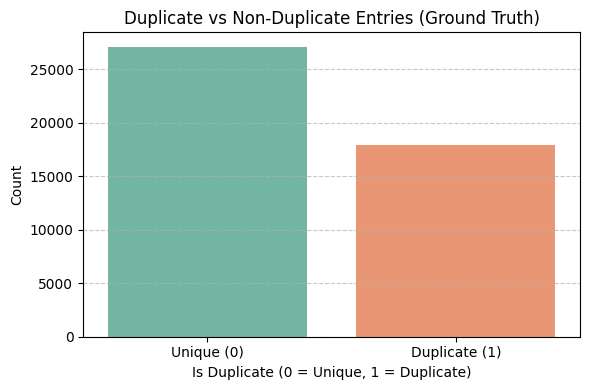


 Rule-Based Model Evaluation Metrics (with noise):
              precision    recall  f1-score   support

           0      0.599     0.166     0.260     27095
           1      0.397     0.832     0.538     17904

    accuracy                          0.431     44999
   macro avg      0.498     0.499     0.399     44999
weighted avg      0.519     0.431     0.370     44999



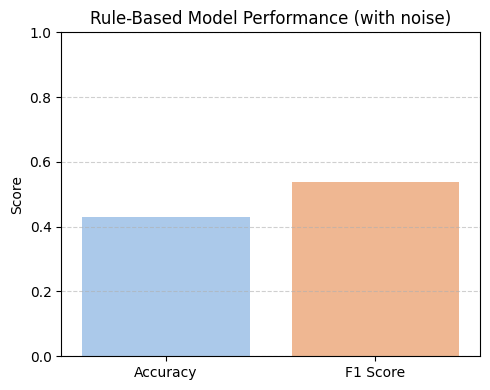

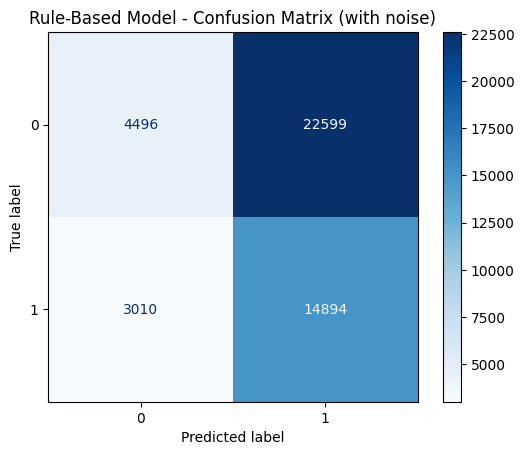

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='is_duplicate', hue='is_duplicate', palette='Set2', legend=False)
plt.title("Duplicate vs Non-Duplicate Entries (Ground Truth)")
plt.xlabel("Is Duplicate (0 = Unique, 1 = Duplicate)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Unique (0)', 'Duplicate (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Evaluation Metrics
y_true = df['is_duplicate']
y_pred = df['predicted_is_duplicate']

print("\n Rule-Based Model Evaluation Metrics (with noise):")
print(classification_report(y_true, y_pred, digits=3))

#Calculate and plot accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.barplot(x=['Accuracy', 'F1 Score'], y=[accuracy, f1], palette='pastel', hue=['Accuracy', 'F1 Score'], legend=False)
plt.ylim(0, 1)
plt.title("Rule-Based Model Performance (with noise)")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plotting Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Rule-Based Model - Confusion Matrix (with noise)")
plt.show()

**Machine Learning Pipeline for Duplicate Entry detection**

In [ ]:
# Load dataset from GitHub
GITHUB_CSV_URL = "https://raw.githubusercontent.com/Atharva2328/Project/main/beachdata.csv"
df = pd.read_csv(GITHUB_CSV_URL)

# Feature and Target Sepration
target_col = 'is_duplicate'

# Drop any irrelevant columns
features = df.columns.tolist()
irrelevant_cols = ['Unnamed: 11', 'Unnamed: 12'] # Identify irrelevant columns
features = [col for col in features if col not in [target_col] + irrelevant_cols] # Exclude target and irrelevant columns

# Separate features(X) and target(Y)
X = df[features]
y = df[target_col]

# Identifying categorical and numerical colums for preprocessing
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns.tolist()


# Split data for training (70%) and testing(30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Numerical preprocessing (handling missing values + scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler_standard', StandardScaler()),
    ('scaler_minmax', MinMaxScaler())
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Adding most common category
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Handling unseen labels gracefully
])

# Combining numerical and categorical transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


Training set: (31499, 10), Test set: (13500, 10)


Baseline Models (Linear Baseline and Non linear baseline)


Training: Logistic Regression
              precision    recall  f1-score   support

           0      0.600     0.857     0.706      8129
           1      0.383     0.134     0.199      5371

    accuracy                          0.570     13500
   macro avg      0.492     0.496     0.452     13500
weighted avg      0.514     0.570     0.504     13500



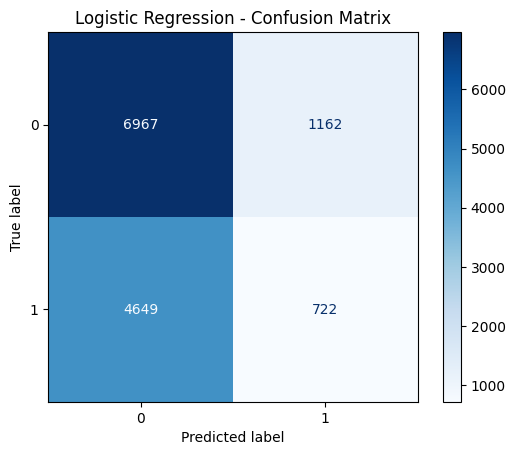


Training: Random Forest
              precision    recall  f1-score   support

           0      0.603     0.997     0.751      8129
           1      0.521     0.005     0.009      5371

    accuracy                          0.602     13500
   macro avg      0.562     0.501     0.380     13500
weighted avg      0.570     0.602     0.456     13500



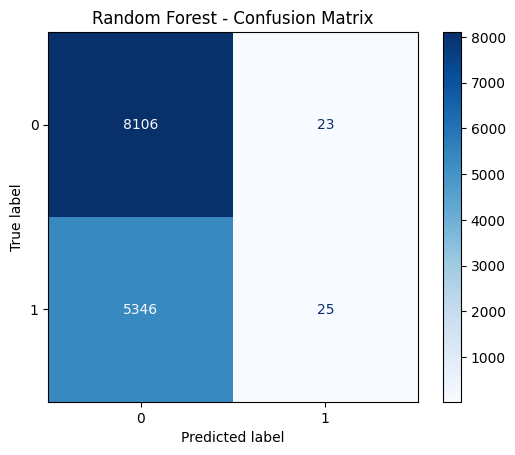

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Model Training
for name, model in models.items():
    pipeline = Pipeline([     # Preprocessing + Model
        ('preprocess', preprocessor),
        ('classifier', model)
    ])

    print(f"\nTraining: {name}")
    pipeline.fit(X_train, y_train)   # Fit Pipeline on training data
    y_pred = pipeline.predict(X_test)  # Predict test set

 # Precision, Recall, F1
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion Matrix Visualisation
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

**Defining Model Accuracy Scores**


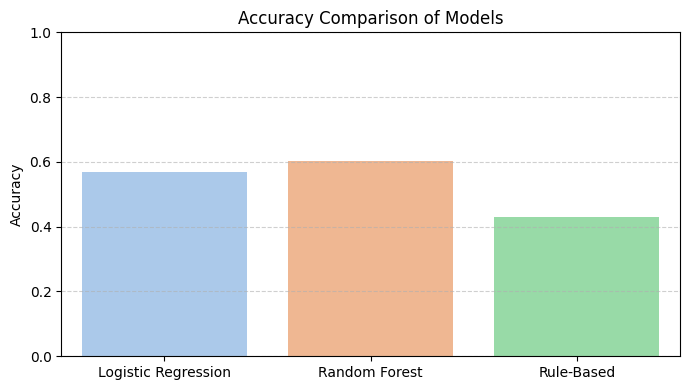


 Absolute Accuracy Differences:
• Logistic Regression vs Random Forest: 0.0320
• Logistic Regression vs Rule-Based:    0.1390
• Random Forest vs Rule-Based:          0.1710


In [ ]:
accuracy_logistic = 0.570
accuracy_rf = 0.602
accuracy_rule_based = 0.431

# Organizing model accuracies into dictionary
model_accuracies = {
    'Logistic Regression': accuracy_logistic,
    'Random Forest': accuracy_rf,
    'Rule-Based': accuracy_rule_based
}

# Calculating pairwise differences
diff_lr_rf = abs(accuracy_logistic - accuracy_rf)
diff_lr_rule = abs(accuracy_logistic - accuracy_rule_based)
diff_rf_rule = abs(accuracy_rf - accuracy_rule_based)

# Creating Bar chart to compare accuracy
plt.figure(figsize=(7, 4))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette='pastel', hue=list(model_accuracies.keys()), legend=False)
plt.title("Accuracy Comparison of Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Output ( Difference between each model's accuracy)
print(f"\n Absolute Accuracy Differences:")
print(f"• Logistic Regression vs Random Forest: {diff_lr_rf:.4f}")
print(f"• Logistic Regression vs Rule-Based:    {diff_lr_rule:.4f}")
print(f"• Random Forest vs Rule-Based:          {diff_rf_rule:.4f}")